## Introduction

Image detection is a good entry point for learning about the use of neural networks, which I aim to learn more about in this project. The problem to be solved in my project is image detection (of handwritten digits, in this case) by using the branch of machine learning that deals with image detection. 

## Data Wrangling

I'll first read in the data and then check for any anomalies. The data exists, among other places, in a scikit-learn repository through Python, where I'll access it for convenience. I'll follow a sample approach provided on this site: http://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html#sphx-glr-auto-examples-linear-model-plot-sparse-logistic-regression-mnist-py. 

In [59]:
%matplotlib inline
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_predict

mnist = fetch_mldata('MNIST')
X = mnist.data.astype('float64')
y = mnist.target

In [25]:
print(X.shape)
print(y.shape)
print(np.unique(y))

(70000, 780)
(70000,)
[0 1 2 3 4 5 6 7 8 9]


# Model Building and Analysis: Logistic Regression

As a baseline comparison to the coming neural network, I will first run a logistic regression. We can use the results here to compare performance against that of the neural network. Logistic regression is commonly used in binary classification problems but can also be used for multinomial ones like this one, in which we are attempting to classify multiple digits. It works by identifying features that have the greatest predictive value (mathematically) on the outcome of interest. 

To start, I will split the data into training and test sets. The training set will be used for model building, with the test data set aside in advance to evaluate how well the model then generalizes. I'll also scale the data using standard scaling, which sets a mean of zero and a variance of one unit. This step makes computations more stable. 

In [46]:
from sklearn.preprocessing import StandardScaler

# train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# standard scaling (mean of zero; unit variance); use of 
scaler = StandardScaler(with_mean = False) #with_mean parameter accommodates sparse matrices 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Next, I will run an initial model with tuned parameters. The L1 penalty sometimes performs better than the L2 with sparse matrices, but frankly, I have not been able to get Python to acknowledge the "saga" solved that is supposed to work in conjunction with L1. (An error message appears saying that saga isn't an option for logistic regression, despite the documentation suggesting otherwise.) As a secondary option, I will use the "sag" solver with L2 regularization, which is another acceptable pairing for multinomial classifications. 

I will also tweak the tolerance (tol in the code) in the model, which expedites the convergence of the algorithm with a large amount of data like we have here. The default tolerance is .0001, so we don't want to deviate too far from that, or the model may not generalize well. 

In [39]:
# logistic regression on training data 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

C_grid = {'C': [0.001, 0.1, 1, 10, 100]}
clf_grid = GridSearchCV(LogisticRegression(multi_class='multinomial', solver='sag', tol=.01, penalty='l2'), 
                        C_grid, cv = 5, scoring = 'accuracy')
clf_grid.fit(X_train, y_train)
print(clf_grid.best_params_, clf_grid.best_score_)

{'C': 100} 0.920464285714


In [40]:
 #check performance on test set
clf_grid_test = LogisticRegression(C = clf_grid.best_params_['C'], multi_class='multinomial', solver='sag', tol=0.1)
clf_grid_test.fit(X_train, y_train)
accuracy_score(clf_grid_test.predict(X_test), y_test)

0.89164285714285718

For a more granular look at the model's performance on the test data, a classification report will show how well it predicted each digit. The aggregate accuracy score above and the metrics below indicate a strong model overall, as precision and recall are both well above .5 (the equivalent of random guessing) for each digit. 

In [44]:
print(classification_report(clf_grid_test.predict(X_test), y_test))

             precision    recall  f1-score   support

          0       0.96      0.95      0.95      1407
          1       0.96      0.93      0.94      1600
          2       0.86      0.90      0.88      1402
          3       0.86      0.88      0.87      1356
          4       0.92      0.90      0.91      1407
          5       0.80      0.88      0.83      1174
          6       0.94      0.92      0.93      1390
          7       0.89      0.92      0.90      1433
          8       0.85      0.80      0.83      1384
          9       0.87      0.83      0.85      1447

avg / total       0.89      0.89      0.89     14000



For comparison, the next table shows digit-level performance for the training data. As expected, the model performs a bit better here, but not so much as to indicate overfitting. 

In [45]:
print(classification_report(clf_grid_test.predict(X_train), y_train))

             precision    recall  f1-score   support

          0       0.96      0.94      0.95      5628
          1       0.97      0.93      0.95      6565
          2       0.87      0.90      0.88      5360
          3       0.87      0.88      0.87      5691
          4       0.91      0.91      0.91      5450
          5       0.82      0.87      0.84      4706
          6       0.94      0.93      0.93      5557
          7       0.90      0.91      0.91      5786
          8       0.85      0.83      0.84      5630
          9       0.87      0.86      0.87      5627

avg / total       0.90      0.90      0.90     56000



Finally, we'll look at a heat map to visualize the performance of the model. The heat map is based on a confusion matrix, which captures the predicted-actual pairings for each digit. Each row/column represents a digit, in order from zero to nine. 

In [52]:
# confusion matrix for each digit 
y_pred = clf_grid_test.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1294    0    6    4    1    8   12    2   13    0]
 [   0 1532   12   10    2   12    2    1   20    1]
 [  24   11 1243   23   23    2   17   24   42    4]
 [  11    8   33 1280    1   51   14   26   30   14]
 [   3    5   12    3 1218    4   15    4   13   58]
 [  16   12    6   56   17 1028   25    9   72   24]
 [  15    7   17    1    7   18 1303    2   20    1]
 [  10   14   16   11   16    1    2 1308    3   57]
 [  13   43   14   44   11   29    2    7 1150   31]
 [  12    8    7   30   63   15    0   45   15 1219]]


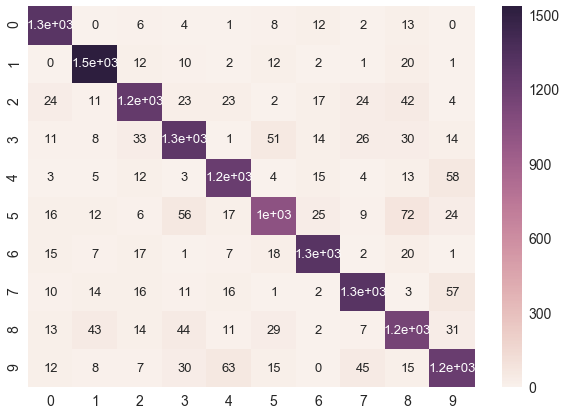

In [63]:
# heat map 
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #set label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 13}) #set font size
plt.show() 

# Model Building and Analysis: Random Forest

For an additional comparison to the coming neural network, I will create a random forest. The structure of this model is notably different from a logistic regression, so its output will be valuable for comparison to the neural network as well. In particular, the random forest makes classification decisions based on a decision trees that rely on series of split points (e.g., where to draw the line between a 2 and a 3) of the different variables. The random forest randomly generates many decision trees to harness the benefits of an ensemble model. 

In [64]:
# train, test, split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.2)

In [67]:
# build/fit model with random forest 
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(random_state = 17) 
model_rf = clf_rf.fit(Xtrain, ytrain)

In [69]:
# model accuracy on test data
print(model_rf.score(Xtest, ytest))

0.9445


In [70]:
# classification report
print(classification_report(clf_rf.predict(Xtest), ytest))

             precision    recall  f1-score   support

          0       0.98      0.96      0.97      1426
          1       0.98      0.97      0.98      1564
          2       0.94      0.92      0.93      1447
          3       0.92      0.92      0.92      1389
          4       0.95      0.94      0.94      1399
          5       0.93      0.94      0.93      1312
          6       0.96      0.96      0.96      1358
          7       0.95      0.96      0.96      1477
          8       0.92      0.93      0.92      1295
          9       0.91      0.95      0.93      1333

avg / total       0.94      0.94      0.94     14000



To improve the model's stability and ability to generalize, I will work on tuning the parameters of the random forest algorithm. This step will help determine the optimal method for using the maximum number of features. (This approach is borrowed from http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py.)

In [ ]:
# no luck using oob error to check parameters -- other ideas?

In [ ]:
# updated random forest model 
new_rf = RandomForestClassifier(random_state = 64, #n_estimators = 30, max_features = 'log2', max_depth = 5)
new_clf = new_rf.fit(Xtrain, ytrain)

# accuracy score and classification report with respect to test data                               
print(new_clf.score(Xtest, ytest))
print(classification_report(clf_rf.predict(Xtest), ytest))

In [ ]:
# confusion matrix for each digit 
y_pred_rf = new_clf.predict(Xtest)
cm_rf = confusion_matrix(ytest, y_pred_rf)
print(cm_rf)

In [ ]:
# heat map 
df_rf = pd.DataFrame(cm_rf)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) 
sns.heatmap(df_rf, annot=True, annot_kws={"size": 13}) 
plt.show() 

In [ ]:
# explain results
# move onto neural network 

In [10]:
import numpy as np
import gzip
import pickle #converts object hierarchy into byte stream

def load_mnist():
    file = gzip.open('mnist.pkl.gz', 'rb') #read in in binary mode
    train, test = pickle.load(file)
    file.close()
    return (train, test)

The next function creates training and test datasets that will be easier to process. The initial training data is a list of 50,000 (x, y) tuples, where x is 784-dimensional (from 28x28 pixels) array of input image and y is a ten-dimensional array capturing the corresponding classification (digit value). The initial test data has the same structure but is a list of 10,000 tuples. 

In [11]:
def data_wrapper():
    train, test = load_mnist()
     #reshape first value (x) in each training tuple into 784D (28x28 pixels) vector
    train_inputs = [np.reshape(x, (784, 1)) for x in train[0]] 
    train_results = [vectorized_result(y) for y in train[1]]
    train_data = zip(train_inputs, train_results)
#validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
#validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in test[0]]
    test_data = zip(test_inputs, test[1])
    return (train_data, test_data) #validation_data,

In [ ]:
# see to-do list before proceeding -- may not need vectorized_result and beyond

The third formula converts a 0-9 digit into a corresponding desired output from the neural network using 1 as a binary marker among zeroes otherwise. It sets up a one-versus-many method of evaluation for the algorithm, in which a yes-or-no decision is made for each potential digit. (For example, in a correct prediction of a 6, the algorithm would choose "no" for the other nine digits and "yes" for 6. The gestalt is also the reason we have a 10-dimensional unit vector -- one dimension for each digit. 

In [12]:
def vectorized_result(j):
    tenD_uv = np.zeros((10, 1)) #create 10D unit vector
    tenD_uv[j] = 1.0 #put 1 in jth position
    return tenD_uv

In [ ]:
# next step: initialize a Network object??